Data is saved in the `data` folder by default. The data is saved according to the pattern described by this python code:
```Python
  def save_state(self):
    self.history[f"g{self.game_state.generation}"] = [player.model_dump() for player in self.players]
    os.makedirs(os.path.dirname(self.save_path), exist_ok=True)
    data = self.game_state.model_dump()
    data["history"] = self.history
    with open(self.save_path, "w") as f:
      json.dump(data, f)
```
Where `self.game_state.generation` is a string indicating the generation number, and `self.save_path` is a string indicating the path to the file where the data is saved.
Also `self.game_state` is the following class:
```Python
class DynamicGameState(BaseModel):
  generation: int
  round: int

class GameConfig(BaseModel):
  donation_multiplier: float = 2
  trace_depth: int = 3
  base_wallet: int = 10
  generations: int = 10
  rounds: int = 12
  players: int = 12
  cutoff_threshold: float = 0.5

class GameState(GameConfig, DynamicGameState):
  pass
```
Finally `player.model_dump()` is a function that serializes the player class in as follows:
```Python
  def model_dump(self):
    return {
      "name": self.name,
      "parents": [parent.name for parent in self.parents],
      "history": [decision.model_dump() for decision in self.history],
      "wallet": self.wallet,
      "strategy": self.strategy
    }
```
Where `self.name` is the player's name, `self.parents` is a list of the player's parents (who are also players), `self.history` is a list of the player's decisions, `self.wallet` is the player's wallet, and `self.strategy` is the player's strategy.
This is what a `Decision` class looks like:
```Python
class DynamicGameState(BaseModel):
  generation: int
  round: int
class Decision(BaseModel):
  # agents data
  recipient_name: str
  donor_name: str
  # game state data
  dynamic_game_state: DynamicGameState
  # donation data
  donation_percent: float
  donation_amount: float
  # donor wallet data
  donor_wallet_before: float
  donor_wallet_after: float
  
  class Config:
    arbitrary_types_allowed = True
```

In [2]:
import json
data_path = "data/gpt_4o_mini/g10_r12_p12/dspy-game_state.json"
output_dir = "data/gpt_4o_mini/g10_r12_p12/"
data = json.load(open(data_path, "r"))
# print data snippet
print(json.dumps(data, indent=4)[:1800] + "...")

{
    "generation": 9,
    "round": 13,
    "donation_multiplier": 2,
    "trace_depth": 3,
    "base_wallet": 10,
    "generations": 10,
    "rounds": 12,
    "players": 12,
    "cutoff_threshold": 0.5,
    "save_path": "dspy-game_state.json",
    "model_name": "gpt-4o-mini",
    "history": {
        "g0": [
            {
                "name": "0_0",
                "parents": [],
                "history": [
                    {
                        "recipient_name": "0_6",
                        "donor_name": "0_0",
                        "dynamic_game_state": {
                            "generation": 0,
                            "round": 0
                        },
                        "donation_percent": 0.2,
                        "donation_amount": 2.0,
                        "donor_wallet_before": 10.0,
                        "donor_wallet_after": 8.0
                    },
                    {
                        "recipient_name": "0_7",
               

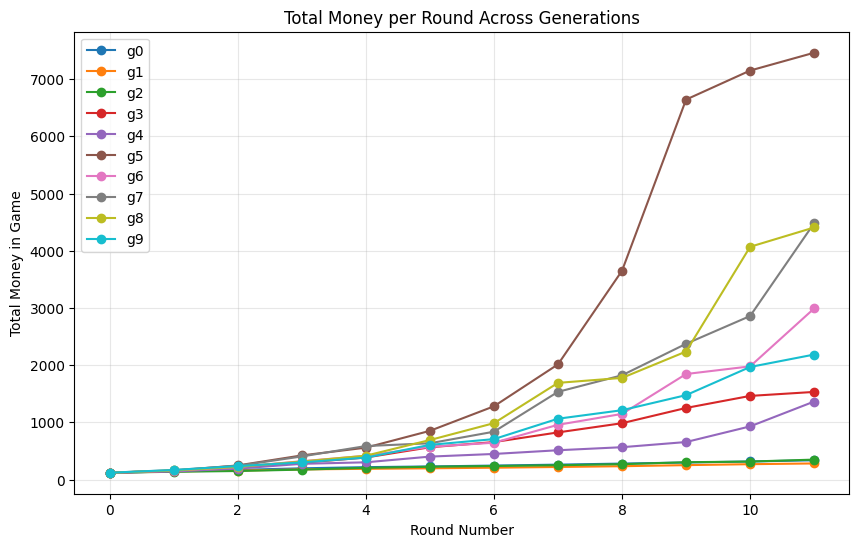

In [3]:
# build a graph line graph where the x-axis is the round number and the y-axis is the total amount of money in the game have this graph overlap for each generation and add a non obstructive legend
import matplotlib.pyplot as plt
import json

# Load the data
with open(data_path, "r") as f:
    data = json.load(f)

rounds = data["rounds"]
generations = data["generations"]

# Create figure and axis
plt.figure(figsize=(10, 6))

generation_totals = []

# Plot line for each generation
for i in range(generations):
    gen_players = data["history"][f"g{i}"]
    total_money_per_round = [0] * rounds
    for j in range(rounds):
        for player in gen_players:
            total_money_per_round[j] += player["history"][j]["donor_wallet_before"]
    generation_totals.append(total_money_per_round)
    
    # Plot this generation's line
    plt.plot(range(rounds), generation_totals[i], marker='o', label=f"g{i}")  # Remove 'g' from generation label

# Customize the plot
plt.xlabel('Round Number')
plt.ylabel('Total Money in Game')
plt.title('Total Money per Round Across Generations')
plt.grid(True, alpha=0.3)
plt.legend()

# save the plot in data directory
plt.savefig(output_dir+"total_money_per_round.png")

# Show the plot
plt.show()



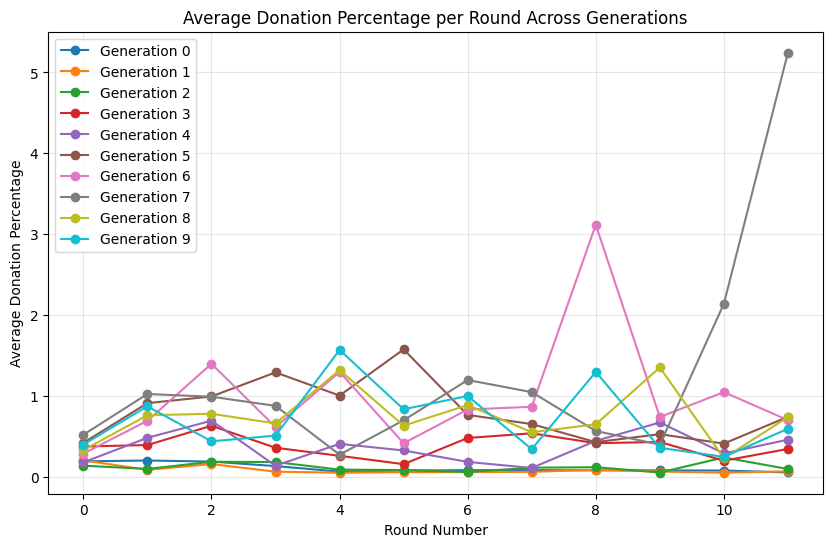

In [4]:
# Create a line graph showing average donation percentages per round across generations
import matplotlib.pyplot as plt
import json

# Load the data
with open(data_path, "r") as f:
    data = json.load(f)

rounds = data["rounds"]
generations = data["generations"]

# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot line for each generation
for i in range(generations):
    gen_players = data["history"][f"g{i}"]
    avg_donation_per_round = [0] * rounds
    for j in range(rounds):
        round_donations = []
        for player in gen_players:
            round_donations.append(player["history"][j]["donation_percent"])
        avg_donation_per_round[j] = sum(round_donations) / len(round_donations)
    
    # Plot this generation's line
    plt.plot(range(rounds), avg_donation_per_round, marker='o', label=f"Generation {i}")

# Customize the plot
plt.xlabel('Round Number')
plt.ylabel('Average Donation Percentage')
plt.title('Average Donation Percentage per Round Across Generations')
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig(output_dir+"avg_donation_percentage.png")

# Show and save the plot
plt.show()

In [10]:
# Find the top donor from generation 6 in round 8
gen_6_players = data["history"]["g6"]
round_8_donations = []
for player in gen_6_players:
    copy = {**player}
    copy["history"] = copy["history"][7]
    round_8_donations.append(copy)
  
sorted_donation = sorted(round_8_donations, key=lambda x: x["history"]["donation_percent"], reverse=True)

print(json.dumps(sorted_donation, indent=2))

[
  {
    "name": "6_5",
    "parents": [
      "5_3",
      "5_4",
      "5_6",
      "5_1",
      "5_0",
      "5_7"
    ],
    "history": {
      "recipient_name": "6_9",
      "donor_name": "6_5",
      "dynamic_game_state": {
        "generation": 6,
        "round": 8
      },
      "donation_percent": 5.0,
      "donation_amount": 104.51627596832634,
      "donor_wallet_before": 104.51627596832634,
      "donor_wallet_after": 0.0
    },
    "wallet": 174.05668400565838,
    "strategy": "My strategy will be to start with a donation of 2.5 units in the first round to establish trust, then in following rounds, increase my donation by 50% if A donates over 70%, decrease it by 30% if A's contribution is below 40%, and always consider B's last donation to adapt my approach, fostering a collaborative environment and maximizing overall cooperation."
  },
  {
    "name": "6_11",
    "parents": [
      "5_3",
      "5_4",
      "5_6",
      "5_1",
      "5_0",
      "5_7"
    ],
    "hist

In [6]:
top_donor

{'name': '6_0', 'donation_percent': 30.0, 'wallet': 242.15200913044765}

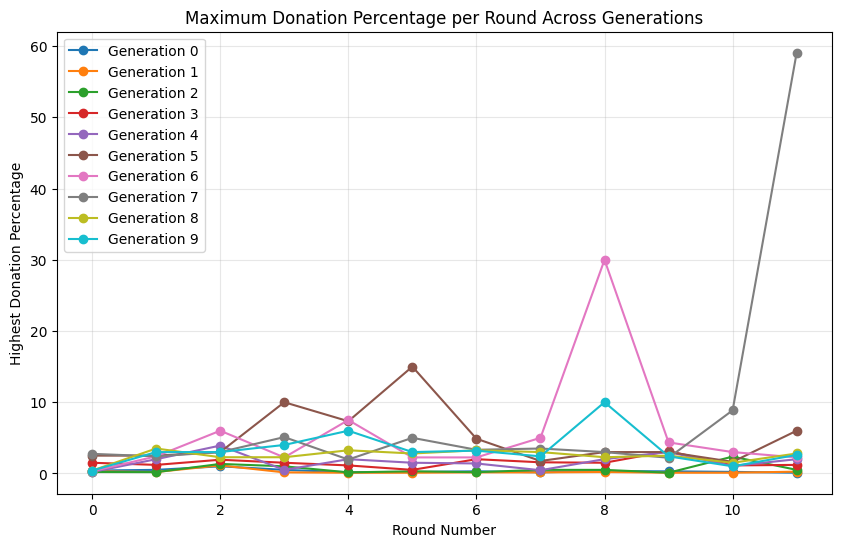

In [9]:
# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot line for each generation
for i in range(generations):
    gen_players = data["history"][f"g{i}"]
    max_donation_per_round = [0] * rounds
    for j in range(rounds):
        round_donations = []
        for player in gen_players:
            round_donations.append(player["history"][j]["donation_percent"])
        max_donation_per_round[j] = max(round_donations)
    
    # Plot this generation's line
    plt.plot(range(rounds), max_donation_per_round, marker='o', label=f"Generation {i}")

# Customize the plot
plt.xlabel('Round Number')
plt.ylabel('Highest Donation Percentage')
plt.title('Maximum Donation Percentage per Round Across Generations')
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig(output_dir+"max_donation_percentage.png")

# Show and save the plot
plt.show()

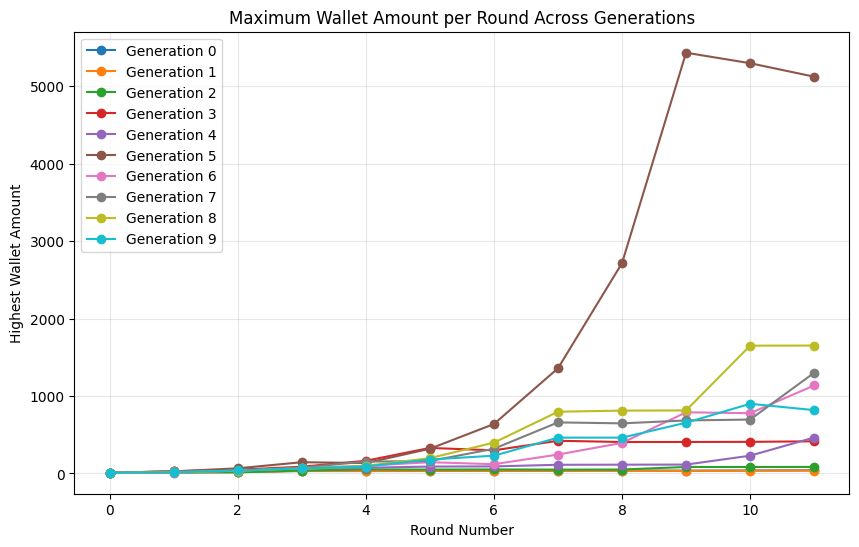

In [10]:
# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot line for each generation
for i in range(generations):
    gen_players = data["history"][f"g{i}"]
    max_wallet_per_round = [0] * rounds
    for j in range(rounds):
        round_wallets = []
        for player in gen_players:
            round_wallets.append(player["history"][j]["donor_wallet_before"])
        max_wallet_per_round[j] = max(round_wallets)
    
    # Plot this generation's line
    plt.plot(range(rounds), max_wallet_per_round, marker='o', label=f"Generation {i}")

# Customize the plot
plt.xlabel('Round Number')
plt.ylabel('Highest Wallet Amount')
plt.title('Maximum Wallet Amount per Round Across Generations')
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig(output_dir+"max_wallet_amount.png")

# Show and save the plot
plt.show()

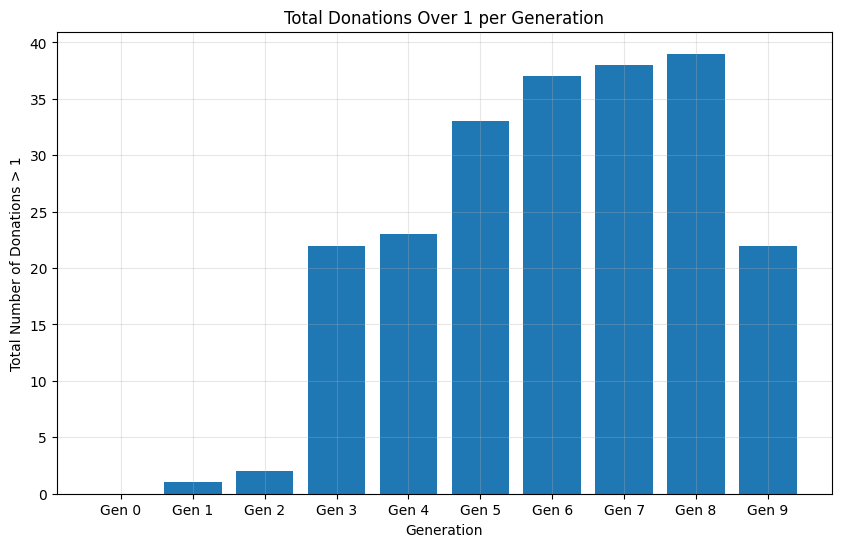

In [6]:
# Create figure and axis
plt.figure(figsize=(10, 6))

# Calculate total donations over 1 for each generation
donations_over_one_by_gen = []
for i in range(generations):
    gen_players = data["history"][f"g{i}"]
    total_count = 0
    
    # Count donations > 1 across all rounds for this generation
    for player in gen_players:
        for round_history in player["history"]:
            if round_history["donation_percent"] > 1:
                total_count += 1
                
    donations_over_one_by_gen.append(total_count)

# Create bar plot
plt.bar(range(generations), donations_over_one_by_gen)

# Customize the plot
plt.xlabel('Generation')
plt.ylabel('Total Number of Donations > 1')
plt.title('Total Donations Over 1 per Generation')
plt.grid(True, alpha=0.3)

# Set x-ticks to show generation numbers
plt.xticks(range(generations), [f"Gen {i}" for i in range(generations)])

plt.savefig(output_dir+"donations_over_one_by_gen.png")

# Show the plot
plt.show()
